In [1]:
# Libraries & Configuration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

In [2]:
# Load Encoded Dataset


DATA_PATH = r"C:\Users\marcu\Documents\Marcus\ITDPA3-34\Project\ITDPA3-34\dataset_encoded.xlsx"

# Choose one target column
TARGET = "academicAvg_num"            # continuous %
#TARGET = "academicPerformance_num"      # ordinal 1–5 rating
# TARGET = "digitalEffect_num"          # ordinal 1–5 perception

TEST_SIZE = 0.30
RANDOM_STATE = 42
CV_FOLDS = 5

# Load the dataset
df = pd.read_excel(DATA_PATH)

# Convert boolean columns to integers (0/1)
for c in df.select_dtypes(include="bool").columns:
    df[c] = df[c].astype(int)

# Confirm load
print("Dataset shape:", df.shape)
print("Columns:", len(df.columns))
print("Target column:", TARGET)

Dataset shape: (110, 44)
Columns: 44
Target column: academicAvg_num


In [ ]:
# =========================
# Prepare Features and Target
# =========================

# Drop ID column, keep all other features
drop_cols = ["ID"]
if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not found in dataset columns.")

feature_cols = [c for c in df.columns if c not in drop_cols + [TARGET]]
X = df[feature_cols].copy()
y = df[TARGET].copy()

# Remove rows with missing data (if any)
mask = (~y.isna()) & (~X.isna().any(axis=1))
X, y = X[mask], y[mask]

# Convert integer columns to float
int_cols = X.select_dtypes(include=["int", "int32", "int64", "Int32", "Int64"]).columns
if len(int_cols) > 0:
    print(f"Converting integer columns to float: {list(int_cols)}")
    X[int_cols] = X[int_cols].astype("float64")

# Train-Test Split (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Converting integer columns to float: ['field_Education', 'field_Health Sciences', 'field_Law', 'field_Other', 'field_Science and Technology', 'institution_Private institution (Eduvos, Varsity College)', 'institution_Public university (e.g. UKZN, Wits, UCT)', 'device_Smartphone', 'device_Tablet', 'frequentPlatform_Netflix', 'frequentPlatform_Other', 'frequentPlatform_TikTok', 'frequentPlatform_WhatsApp', 'frequentPlatform_YouTube', 'primaryReason_Entertainment and relaxaction', 'primaryReason_News and current events', 'primaryReason_Other', 'primaryReason_Social interactions', 'distractionMethod_Other', 'distractionMethod_Setting app timers or screen limits', 'distractionMethod_Studying in a place without easy access to devices', 'distractionMethod_Turning off notifications or placing devices on silent mode', 'perception_It has no significant impact', 'perception_It mostly distracts me academically', 'perception_It mostly helps me academically', 'distraction_Instagram', 'distraction_Net

In [15]:
# Define Models and Parameters


ridge_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # safe for sparse-like one-hot matrices
    ("model", Ridge(random_state=RANDOM_STATE))
])
ridge_grid = {
    "model__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]
}

dt = DecisionTreeRegressor(random_state=RANDOM_STATE)
dt_grid = {
    "max_depth": [3, 4, 5, 8, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
}

rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
rf_grid = {
    "n_estimators": [200, 500],
    "max_depth": [None, 8, 12],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", 0.5],
}

In [16]:
# Helper Function for Training & Reporting


def train_and_report(model_or_pipe, param_grid, name):
    """Performs GridSearchCV with cross-validation and evaluates on test data."""
    cv = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    gs = GridSearchCV(
        model_or_pipe, param_grid,
        cv=cv, n_jobs=-1, scoring="neg_root_mean_squared_error", refit=True
    )
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    y_pred = best.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)

    print(f"\n=== {name} ===")
    print("Best params:", gs.best_params_)
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE : {mae:.4f}")
    print(f"Test R^2 : {r2:.4f}")

    return best, {"rmse": rmse, "mae": mae, "r2": r2}

In [17]:
# Train Models & Evaluate


best_ridge, ridge_metrics = train_and_report(ridge_pipe, ridge_grid, "Ridge Regression")
best_dt, dt_metrics       = train_and_report(dt, dt_grid, "Decision Tree")
best_rf, rf_metrics       = train_and_report(rf, rf_grid, "Random Forest")


=== Ridge Regression ===
Best params: {'model__alpha': 100.0}
Test RMSE: 9.5348
Test MAE : 8.1947
Test R^2 : 0.0517

=== Decision Tree ===
Best params: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
Test RMSE: 9.7605
Test MAE : 8.0752
Test R^2 : 0.0063

=== Random Forest ===
Best params: {'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 200}
Test RMSE: 8.5254
Test MAE : 6.8433
Test R^2 : 0.2418


In [18]:
# Interpretability: Ridge Coefficients
def print_top_ridge_coeffs(ridge_pipe, top_k=15):
    ridge = ridge_pipe.named_steps["model"]
    coefs = pd.Series(ridge.coef_, index=feature_cols)
    top = coefs.reindex(coefs.abs().sort_values(ascending=False).head(top_k).index)
    print("\nTop Ridge coefficients (by absolute value):")
    for feat, val in top.items():
        print(f"{feat:50s} {val: .4f}")

print_top_ridge_coeffs(best_ridge, top_k=15)


Top Ridge coefficients (by absolute value):
academicPerformance_num                             1.6028
perception_It has no significant impact             0.8335
frequentPlatform_YouTube                           -0.8157
negativeEffect_num                                 -0.7309
frequentPlatform_Netflix                            0.6845
perception_It mostly distracts me academically     -0.6562
frequentPlatform_Other                             -0.5929
frequentPlatform_TikTok                             0.5877
field_Other                                         0.5565
institution_Public university (e.g. UKZN, Wits, UCT) -0.5527
device_Tablet                                       0.5403
perception_It mostly helps me academically         -0.5402
distractionMethod_Other                            -0.4816
institution_Private institution (Eduvos, Varsity College)  0.4147
frequentPlatform_WhatsApp                           0.3862


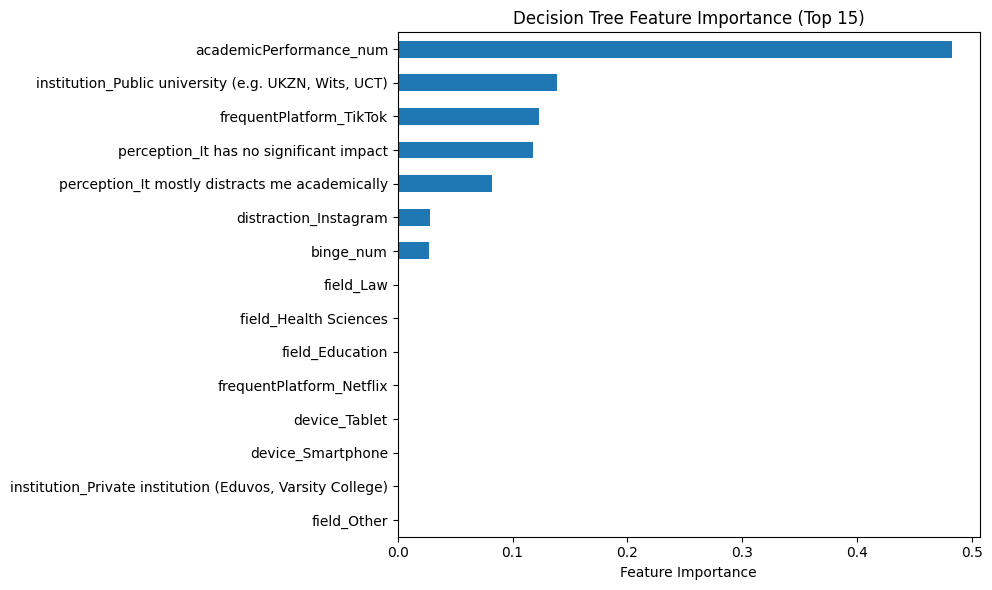

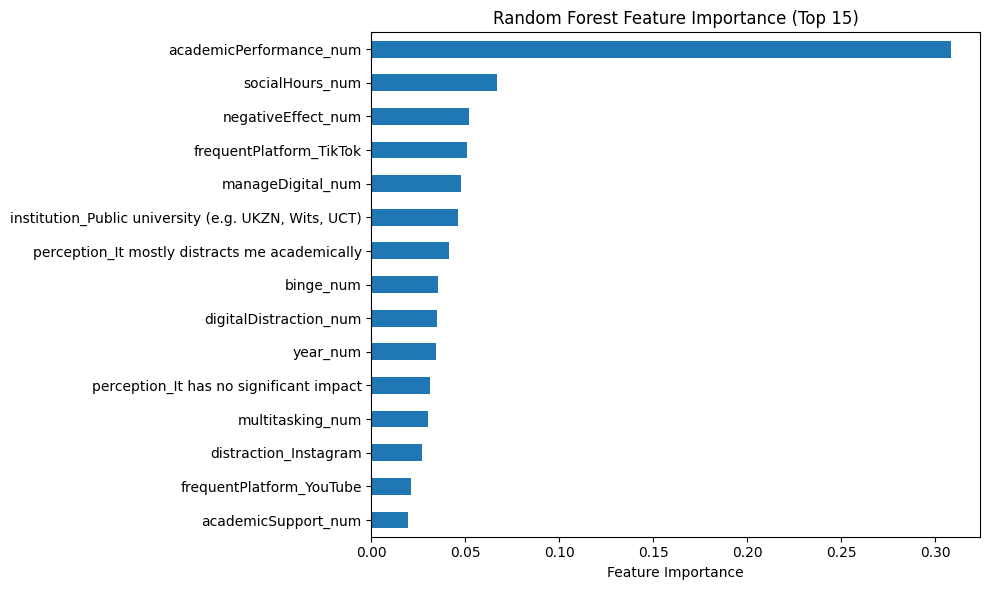

In [19]:
# Interpretability: Tree & Forest Feature Importances

def plot_feature_importance(model, title, top_k=15):
    if not hasattr(model, "feature_importances_"):
        return
    importances = pd.Series(model.feature_importances_, index=feature_cols)
    top = importances.sort_values(ascending=False).head(top_k)
    plt.figure(figsize=(10, 6))
    top.iloc[::-1].plot(kind="barh")
    plt.title(title)
    plt.xlabel("Feature Importance")
    plt.tight_layout()
    plt.show()

plot_feature_importance(best_dt, "Decision Tree Feature Importance (Top 15)")
plot_feature_importance(best_rf, "Random Forest Feature Importance (Top 15)")

In [20]:
# Model Comparison & Best Model Selection
def choose_winner(metrics_dict):
    items = list(metrics_dict.items())
    items.sort(key=lambda kv: (kv[1]["rmse"], -kv[1]["r2"]))  # best RMSE, then best R^2
    return items[0]

winner_name, winner_metrics = choose_winner({
    "Ridge": ridge_metrics,
    "DecisionTree": dt_metrics,
    "RandomForest": rf_metrics
})

print(f"\n>>> Best Performing Model: {winner_name}")
print(f"RMSE = {winner_metrics['rmse']:.4f}, R² = {winner_metrics['r2']:.4f}")


>>> Best Performing Model: RandomForest
RMSE = 8.5254, R² = 0.2418



=== Model Comparison (sorted by RMSE) ===
        model     rmse      mae       r2
Random Forest 8.525403 6.843262 0.241846
        Ridge 9.534769 8.194706 0.051696
Decision Tree 9.760549 8.075196 0.006253


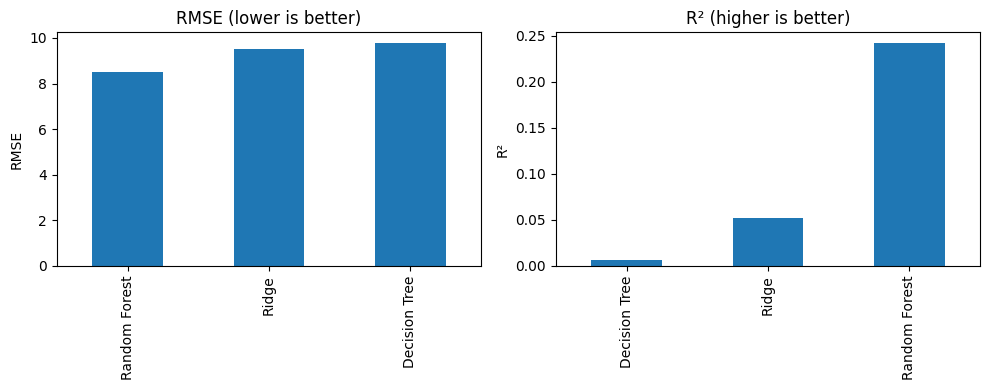

In [21]:
# Results Table & Comparison Plots

results = pd.DataFrame([
    {"model": "Ridge",         **ridge_metrics},
    {"model": "Decision Tree", **dt_metrics},
    {"model": "Random Forest", **rf_metrics},
])

print("\n=== Model Comparison (sorted by RMSE) ===")
print(results.sort_values("rmse").to_string(index=False))

# Side-by-side bars for RMSE and R^2
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
results.sort_values("rmse").plot(x="model", y="rmse", kind="bar", ax=axes[0], legend=False)
axes[0].set_title("RMSE (lower is better)"); axes[0].set_xlabel(""); axes[0].set_ylabel("RMSE")

results.sort_values("r2").plot(x="model", y="r2", kind="bar", ax=axes[1], legend=False)
axes[1].set_title("R² (higher is better)"); axes[1].set_xlabel(""); axes[1].set_ylabel("R²")
plt.tight_layout(); plt.show()

Winner: Random Forest
RMSE=8.5254  MAE=6.8433  R²=0.2418


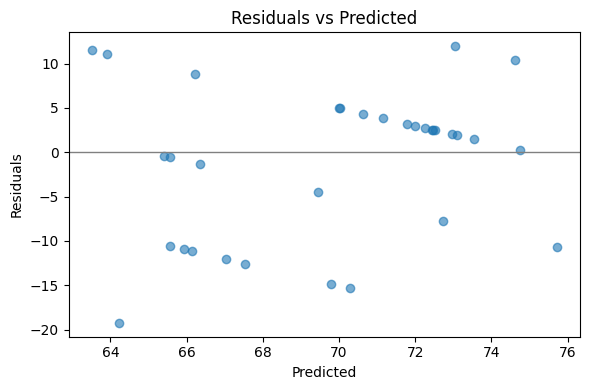

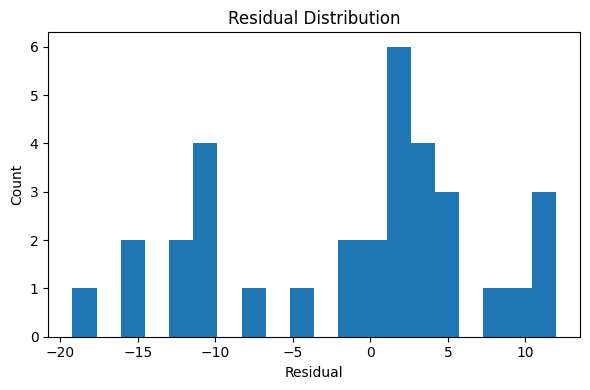

In [22]:
# Residual Diagnostics (Winner)

metrics_dict = {"Ridge": ridge_metrics, "Decision Tree": dt_metrics, "Random Forest": rf_metrics}
winner_name = min(metrics_dict.items(), key=lambda kv: (kv[1]["rmse"], -kv[1]["r2"]))[0]
model_map = {"Ridge": best_ridge, "Decision Tree": best_dt, "Random Forest": best_rf}
best_model = model_map[winner_name]

y_pred = best_model.predict(X_test)
resid = y_test - y_pred

print(f"Winner: {winner_name}")
print(f"RMSE={root_mean_squared_error(y_test, y_pred):.4f}  "
      f"MAE={mean_absolute_error(y_test, y_pred):.4f}  "
      f"R²={r2_score(y_test, y_pred):.4f}")

# Residuals vs Predicted
plt.figure(figsize=(6,4))
plt.scatter(y_pred, resid, alpha=0.6)
plt.axhline(0, color="gray", lw=1)
plt.xlabel("Predicted"); plt.ylabel("Residuals"); plt.title("Residuals vs Predicted")
plt.tight_layout(); plt.show()

# Residual distribution
plt.figure(figsize=(6,4))
plt.hist(resid, bins=20)
plt.title("Residual Distribution"); plt.xlabel("Residual"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

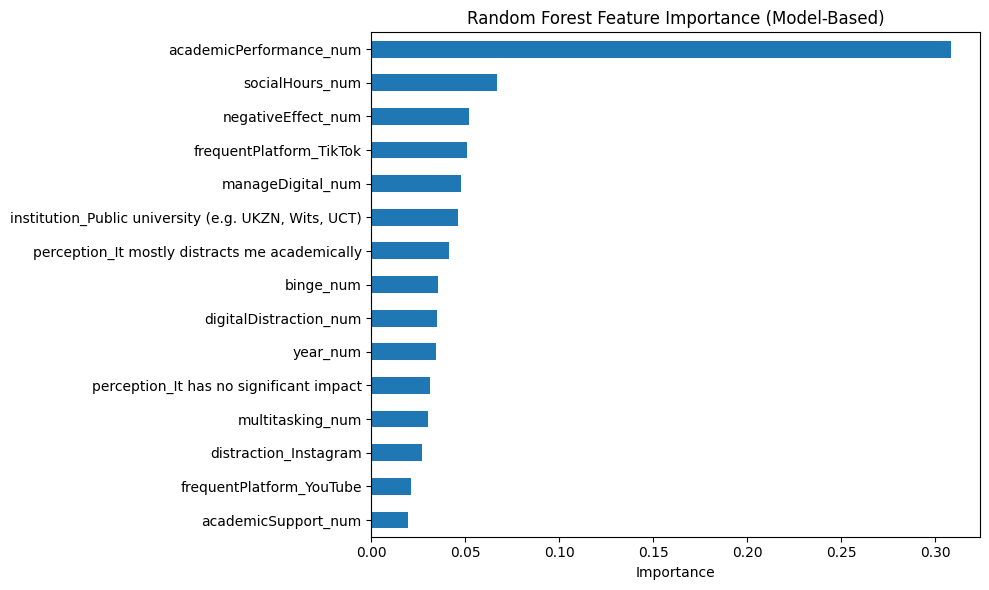

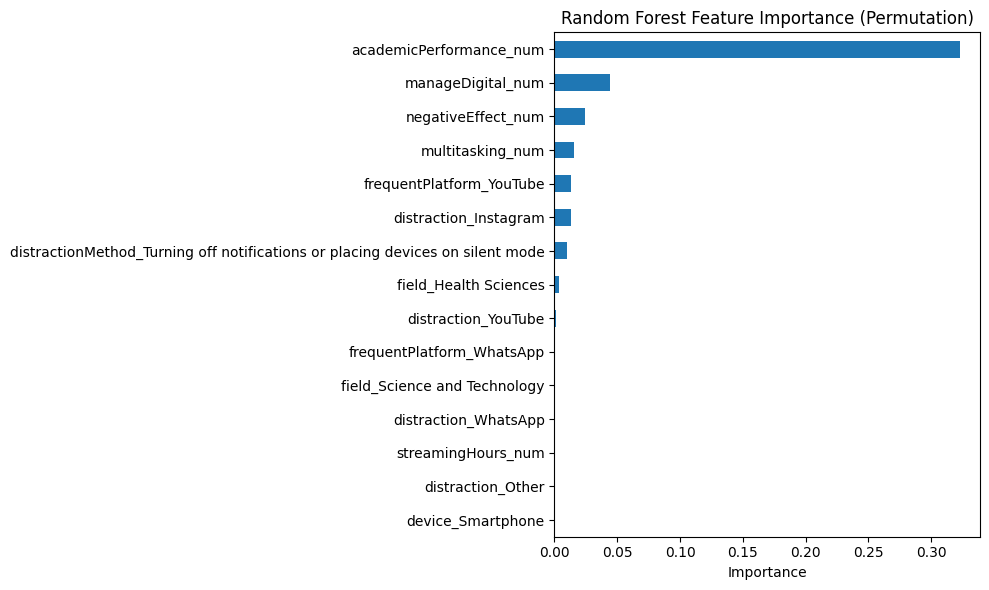

In [23]:
# Robust Feature Importance: Model-Based + Permutation

def plot_importances(importances: pd.Series, title: str, top_k=15):
    top = importances.sort_values(ascending=False).head(top_k)
    plt.figure(figsize=(10,6))
    top.iloc[::-1].plot(kind="barh")
    plt.title(title); plt.xlabel("Importance"); plt.tight_layout(); plt.show()

# 1) Model-based (tree/forest) or coefficients (ridge pipeline)
if hasattr(best_model, "feature_importances_"):
    fi = pd.Series(best_model.feature_importances_, index=feature_cols)
    plot_importances(fi, f"{winner_name} Feature Importance (Model-Based)")
elif winner_name == "Ridge":
    coefs = pd.Series(best_model.named_steps["model"].coef_, index=feature_cols)
    plot_importances(coefs.abs(), "Ridge Coefficients (|value|)")

# 2) Permutation importance (agnostic, more robust)
perm = permutation_importance(best_model, X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1)
perm_series = pd.Series(perm.importances_mean, index=feature_cols)
plot_importances(perm_series, f"{winner_name} Feature Importance (Permutation)")

Top features for effect plots: ['academicPerformance_num', 'manageDigital_num', 'negativeEffect_num']


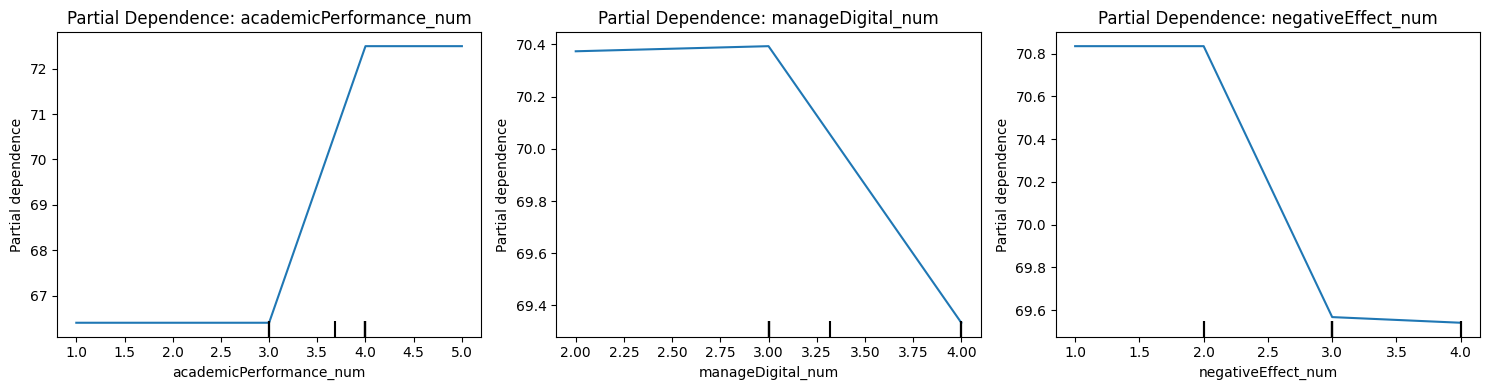

In [24]:
# Effect Plots: Partial Dependence for Top Drivers

top_features = perm_series.sort_values(ascending=False).head(3).index.tolist()
print("Top features for effect plots:", top_features)

fig, ax = plt.subplots(1, len(top_features), figsize=(5*len(top_features), 4))
if len(top_features) == 1:
    ax = [ax]

for i, feat in enumerate(top_features):
    try:
        PartialDependenceDisplay.from_estimator(best_model, X_test, [feat], ax=ax[i])
        ax[i].set_title(f"Partial Dependence: {feat}")
    except Exception as e:
        ax[i].set_title(f"{feat} (PDP failed)")
        print(f"PDP skipped for {feat}: {e}")

plt.tight_layout(); plt.show()

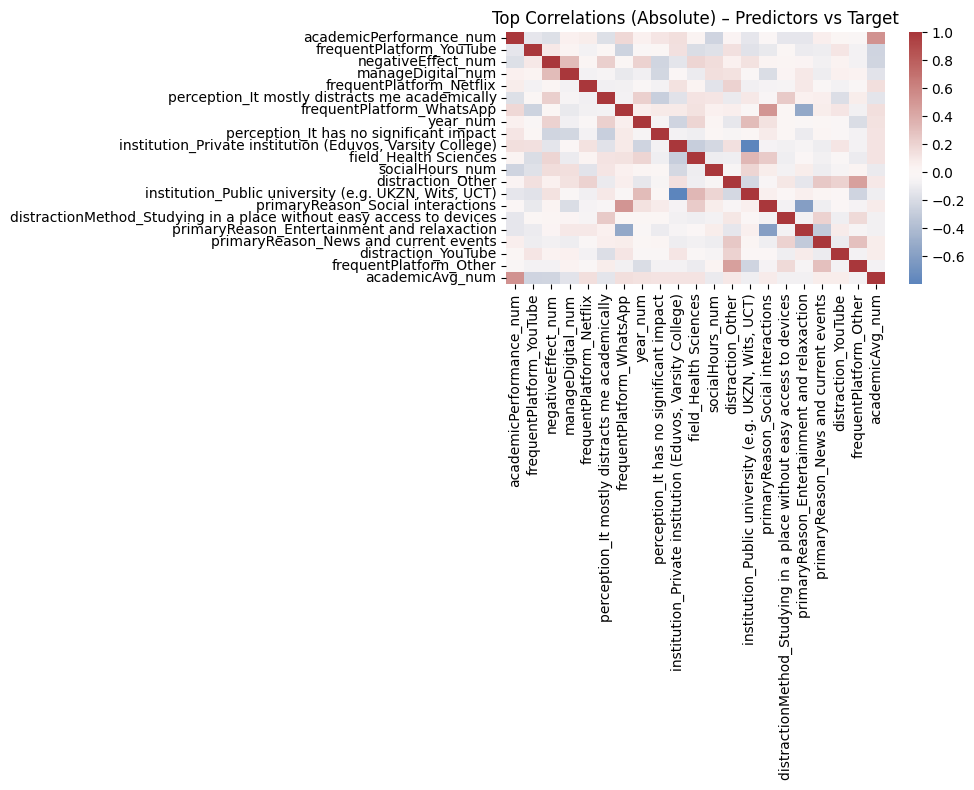

Top 10 absolute correlations with target:
academicPerformance_num                                      0.527659
frequentPlatform_YouTube                                     0.244112
negativeEffect_num                                           0.235958
manageDigital_num                                            0.154559
frequentPlatform_Netflix                                     0.149911
perception_It mostly distracts me academically               0.149911
frequentPlatform_WhatsApp                                    0.145544
year_num                                                     0.124643
perception_It has no significant impact                      0.121581
institution_Private institution (Eduvos, Varsity College)    0.121581


In [25]:
# Correlation Heatmap of Top Signals vs Target

df_corr = X.copy()
df_corr[TARGET] = y.values

corr = df_corr.corr(numeric_only=True)
top_abs = corr[TARGET].drop(TARGET).abs().sort_values(ascending=False).head(20)
top_cols = top_abs.index.tolist() + [TARGET]

plt.figure(figsize=(10,8))
sns.heatmap(corr.loc[top_cols, top_cols], annot=False, cmap="vlag", center=0)
plt.title("Top Correlations (Absolute) – Predictors vs Target")
plt.tight_layout(); plt.show()

print("Top 10 absolute correlations with target:")
print(top_abs.head(10).to_string())

In [26]:
# Save Best Model for Reuse/Submission

OUT_PATH = Path("best_model_academicAvg.pkl")
joblib.dump(best_model, OUT_PATH)
print(f"Saved best model to: {OUT_PATH.resolve()}")

Saved best model to: C:\Users\marcu\Documents\Marcus\ITDPA3-34\Project\best_model_academicAvg.pkl
